In [1]:
import neat
import os
import evogym.envs
from evogym import is_connected, has_actuator, get_full_connectivity, hashable
import numpy as np
import dill
import pickle as pkl
import sys
sys.path.append('../')

from hyperneat.hyperNEAT import create_phenotype_network
from hyperneat.substrate import Substrate
from hyperneat.visualize import draw_net
from dynamic_env.traverser import DynamicObstacleTraverser
from dynamic_env.env_config import EnvConfig


import itertools as it
import time
import imageio

from matplotlib import pyplot as plt


from sgr.substrates import morph_substrate, control_substrate
from sgr.generate_robot import generate_robot, eval_robot_constraint
from sgr.evogym_sim import simulate_env
from sgr.body_speciation import CustomGenome
from grid_world.graph import Graph
from grid_world.node import Node
from grid_world.tasks import *
from copy import deepcopy
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
def get_robot(genome, neat_config, env, genome_type):
    if genome.robot is not None:
        robot = genome.robot
    else:
        cppn = neat.nn.FeedForwardNetwork.create(genome, neat_config)
        design_substrate = morph_substrate(5, genome_type)
        design_net = create_phenotype_network(cppn, design_substrate)
        robot = generate_robot(design_net, 5)
        
    if not eval_robot_constraint(robot):
        return robot, None
    connections = get_full_connectivity(robot)
    
    env = evogym.envs.gym.make(env, body=robot, connections=connections)
    img = env.render(mode='img')
    env.close()
    return robot, img

In [3]:
with open(f"../island_cp/cp_locomotion_5000.pkl", "rb") as file:
    grid: Graph = pkl.load(file)
genome_type = grid.params.substrate_type
CustomGenome.robot_func = lambda self, net, config: generate_robot(net, grid.d_nodes["0"].sgr_pop.robot_size)
CustomGenome.substrate = morph_substrate(grid.d_nodes["0"].sgr_pop.robot_size, genome_type)
CustomGenome.robot_size = grid.d_nodes["0"].sgr_pop.robot_size
CustomGenome.spec_genotype_weight =  grid.params.spec_genotype_weight
CustomGenome.spec_phenotype_weight = grid.params.spec_phenotype_weight

Walker-v0 24230 6.3	UpStepper-v0 24998 2.4	Hurdler-v0 12446 2.76	Walker-v0 18436 6.8	
Walker-v0 24230 6.3	UpStepper-v0 25128 1.98	Hurdler-v0 12446 2.76	Walker-v0 18436 6.8	
Walker-v0 24230 6.3	UpStepper-v0 25085 0.79	Hurdler-v0 12446 2.76	Walker-v0 18436 6.8	
Walker-v0 24230 6.3	UpStepper-v0 19132 0.66	Hurdler-v0 12446 2.76	Walker-v0 18436 6.8	


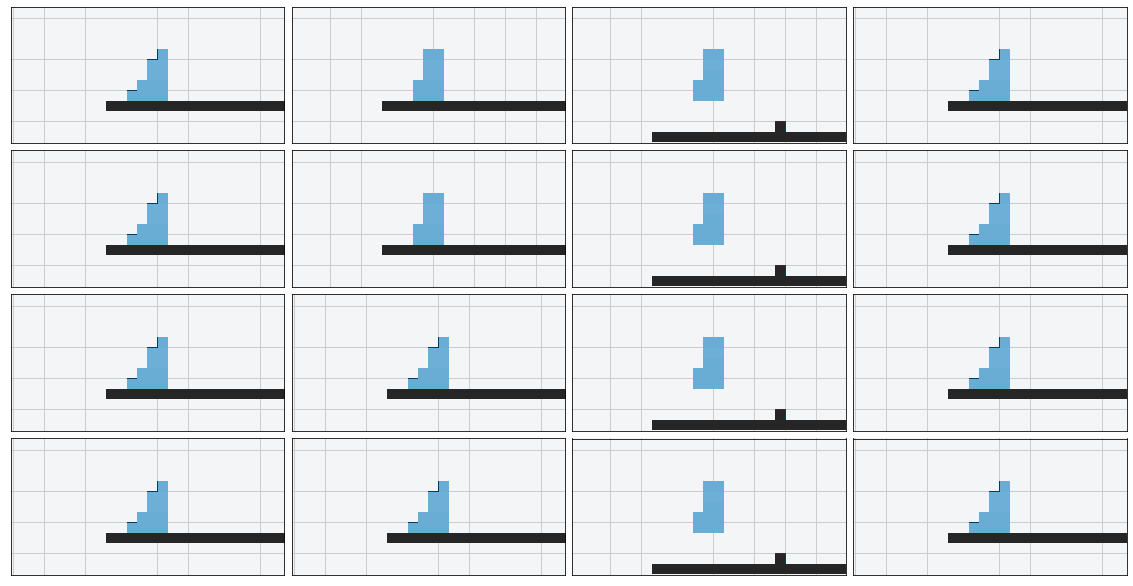

In [4]:
n_rows=4
n_cols=4

fig = plt.figure(1,(20,20))
grid_img = ImageGrid(fig, 111,
                 nrows_ncols=(n_rows,n_cols),
                 axes_pad=0.1,
                 share_all=True
                 )

grid_img[0].get_yaxis().set_ticks([])
grid_img[0].get_xaxis().set_ticks([])
cont = 0
for key, value in grid.d_nodes.items():
    best_genome = None
    best_genome_fit = -100000
    for g in value.sgr_pop.pop.population.values():
        # print(g.key, g.fitness)
        if g.fitness != None and g.fitness > best_genome_fit:
            best_genome = g
            best_genome_fit = g.fitness
    # best_genome = value.sgr_pop.best_genome
    fit = np.round(best_genome_fit, 2)
    print(f"{value.task} {best_genome.key} {fit}", end="\t")
    if cont%n_cols==n_cols-1:
        print()
    
    robot, img = get_robot(best_genome, value.sgr_pop.neat_config, value.task, genome_type) 
    if img is not None:
        # print(ag.robot)
        aux = Image.fromarray(img, 'RGB')
        # display(aux.resize((aux.size[0]//3, aux.size[1]//3)))
        grid_img[cont].imshow(aux,interpolation='none')
    cont += 1